In [315]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [316]:
sns.set(font_scale=1.4)
cp = sns.color_palette()
warnings.filterwarnings("ignore")  # Ignore divide by zero numpy warnings
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# For 2 groups

In [368]:
def plot_dRL(ax, Y0_100, Y1_100, lamQ, lamF):
    N_POINTS = 21
    points = np.linspace(0, 1, N_POINTS)
    # Generate permutations of points for various Y0_lam and Y1_lam
    grid = np.stack(np.meshgrid([Y0_100], [Y1_100], points, points), -1).reshape(-1, 4)
    dRQ = np.empty(N_POINTS**2)
    dRF = np.empty(N_POINTS**2)

    # Compute dRQ and dRF values for each Y_lam permutation
    for i, point in enumerate(grid):
        _Y0_100, _Y1_100, _Y0_lam, _Y1_lam = point
        dRQ[i] = .5*(_Y0_lam - _Y0_100) + .5*(_Y1_lam - _Y1_100)
        dRF[i] = abs(_Y1_100 - _Y0_100) - abs(_Y1_lam - _Y0_lam)

    # Generate dataframe for convenience
    df = pd.DataFrame(grid, columns=['Y0_100', 'Y1_100', 'Y0_lam', 'Y1_lam'])
    df['dRQ'] = dRQ
    df['dRF'] = dRF
    df['dRF'] = dRF
    # Compute -RF/RQ which is equal to the lamQ/lamF ratio
    df['neg_dRF_over_dRQ'] = -1 * dRF / dRQ
    df['lamQdRQ_plus_lamFdRF'] = (lamQ*dRQ + lamF*dRF) / (lamQ+lamF)

    df = df.copy()
    df.loc[df['lamQdRQ_plus_lamFdRF'] < 0, 'lamQdRQ_plus_lamFdRF'] = np.nan
    
    # Generate pivot table for heatmap
    piv = df.pivot(columns='Y1_lam', index='Y0_lam', values='lamQdRQ_plus_lamFdRF')
    
    # Plot heatmap
    ax = sns.heatmap(piv, ax=ax, vmin=0, # vmin=0 so that anything less than 0 is black
                     vmax=.5, cmap='rocket_r')  # vmax=.5 is max dRlam gain
    cbar = ax.collections[0].colorbar
    cbar.set_label('$\Delta R^\lambda$', rotation=0, labelpad=25)
    ax.invert_yaxis()
    ax.set_xlabel('$Y^0_\lambda$')
    ax.set_ylabel('$Y^1_\lambda$', rotation=0, labelpad=20)
    ax.scatter([Y0_100*ax.get_xlim()[1]], [Y1_100*ax.get_ylim()[1]],
               label=f'$(Y^0_{{100}}, Y^1_{{100}})$=({Y0_100}, {Y1_100})', s=100)
    ax.legend(loc='lower right')
    lamQ = 1 if lamQ == 2 else lamQ
    ax.set_title(f'$\lambda^Q={lamQ}, \lambda^F={lamF}$')
    xlabels = [f'{x:.1f}' for x in np.linspace(df['Y0_lam'].min(), df['Y0_lam'].max(), len(ax.get_xticks()))]
    ylabels = [f'{y:.1f}' for y in np.linspace(df['Y1_lam'].min(), df['Y1_lam'].max(), len(ax.get_yticks()))]
    ax.set_xticklabels(xlabels, ha='center', rotation=0)
    ax.set_yticklabels(ylabels, va='center')
    return ax, df

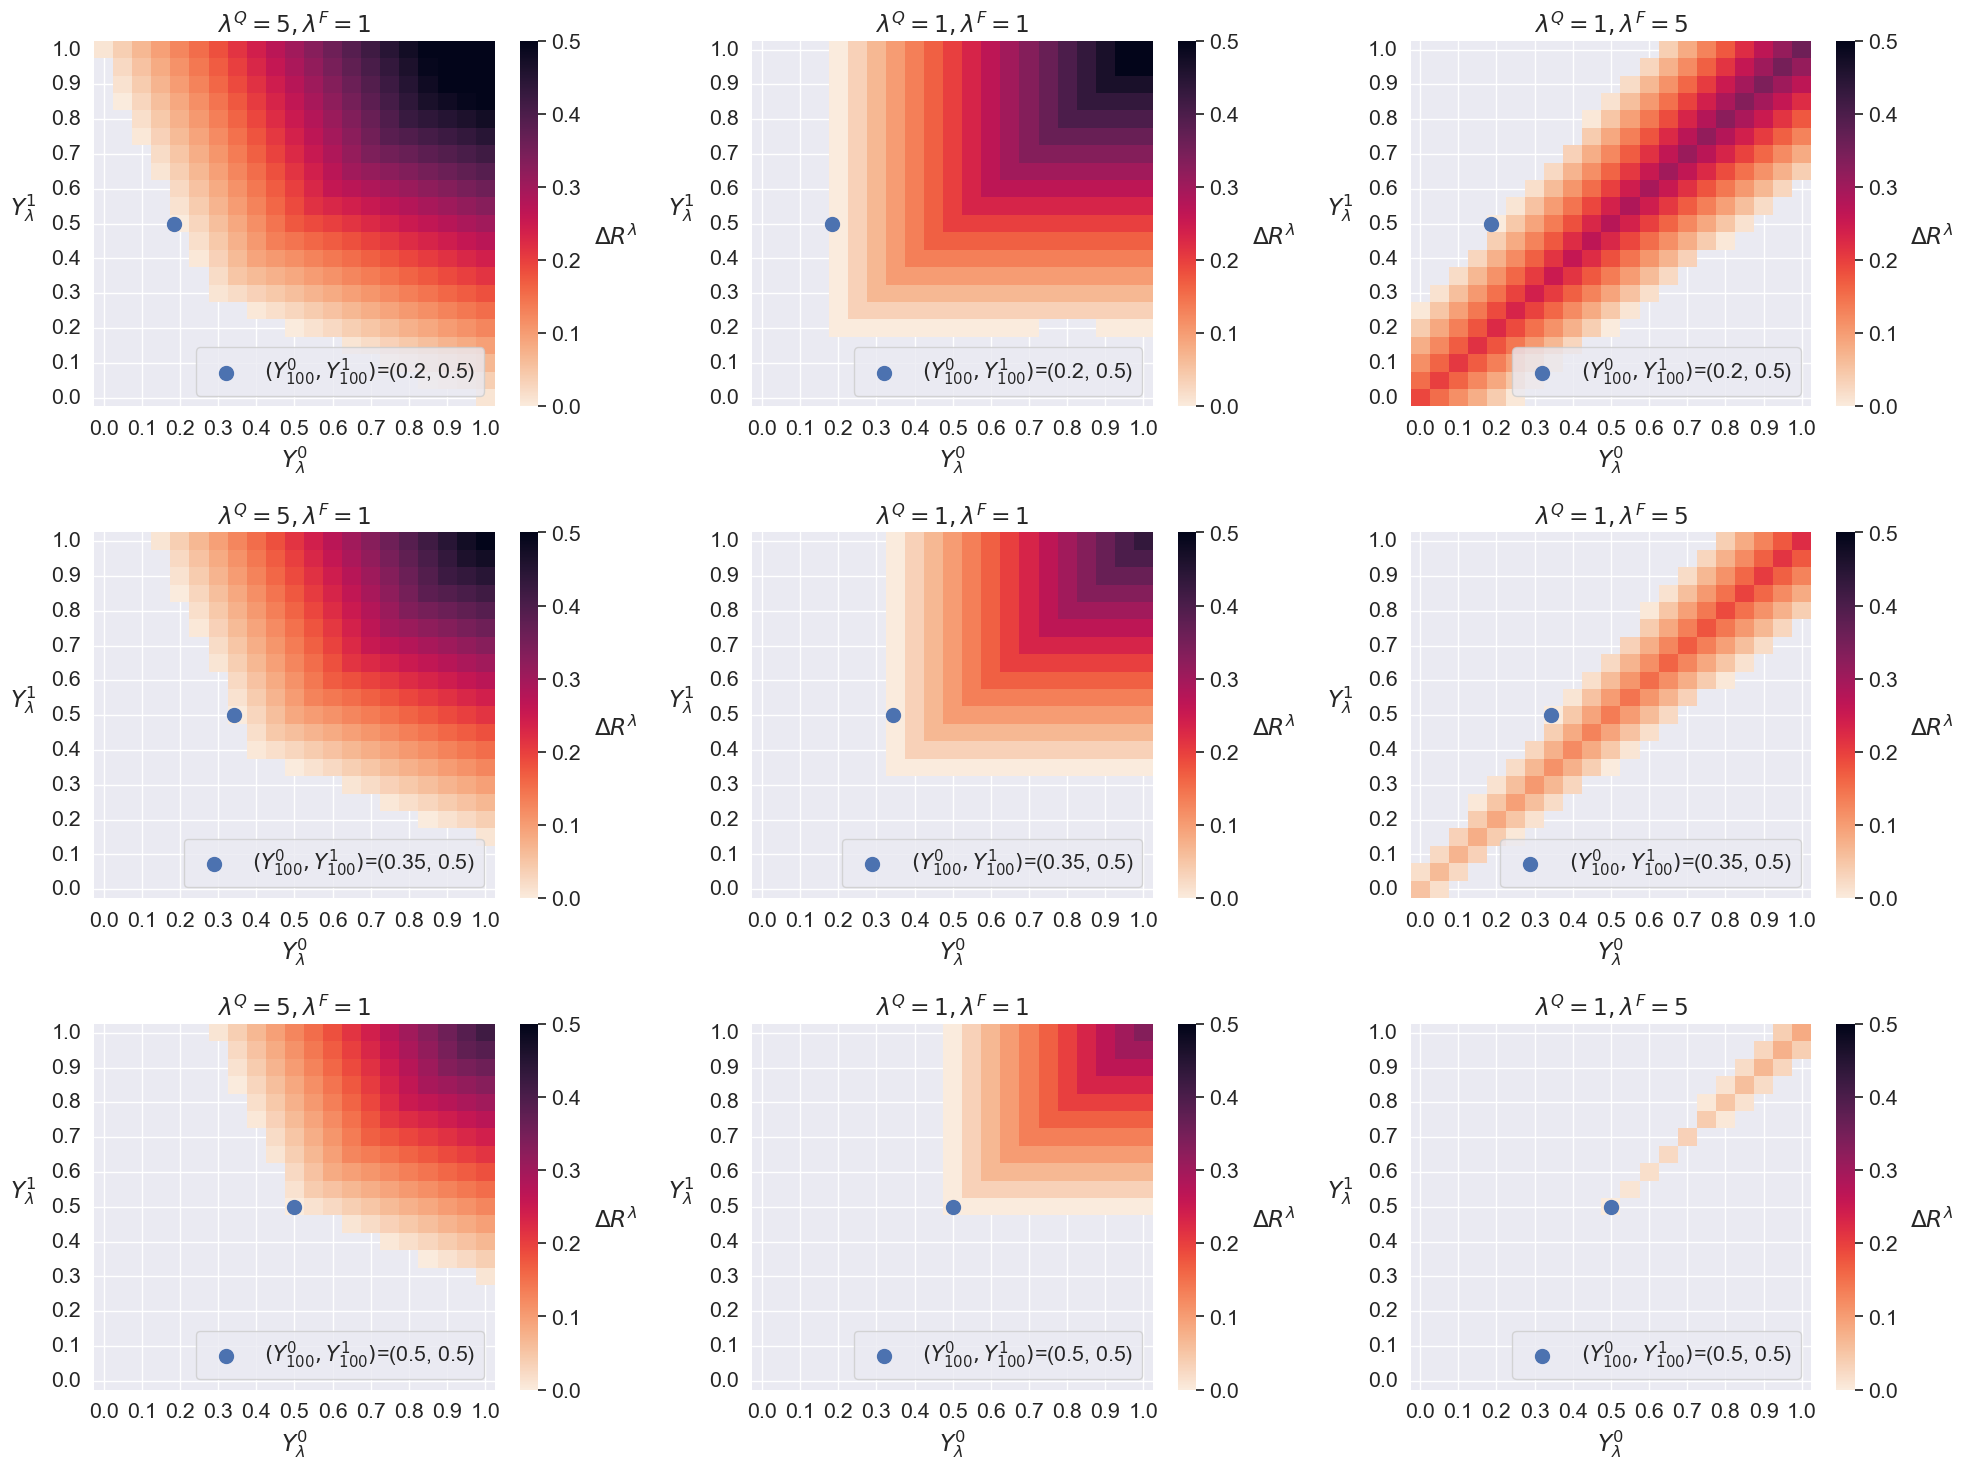

In [370]:
sns.set(font_scale=1.4)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

_, df1 = plot_dRL(ax=axes[0][0], Y0_100=.20, Y1_100=.5, lamQ=5, lamF=1)
_, df2 = plot_dRL(ax=axes[0][1], Y0_100=.20, Y1_100=.5, lamQ=2, lamF=1)
_, df3 = plot_dRL(ax=axes[0][2], Y0_100=.20, Y1_100=.5, lamQ=1, lamF=5)
_, df4 = plot_dRL(ax=axes[1][0], Y0_100=.35, Y1_100=.5, lamQ=5, lamF=1)
_, df5 = plot_dRL(ax=axes[1][1], Y0_100=.35, Y1_100=.5, lamQ=2, lamF=1)
_, df6 = plot_dRL(ax=axes[1][2], Y0_100=.35, Y1_100=.5, lamQ=1, lamF=5)
_, df7 = plot_dRL(ax=axes[2][0], Y0_100=.50, Y1_100=.5, lamQ=5, lamF=1)
_, df8 = plot_dRL(ax=axes[2][1], Y0_100=.50, Y1_100=.5, lamQ=2, lamF=1)
_, df9 = plot_dRL(ax=axes[2][2], Y0_100=.50, Y1_100=.5, lamQ=1, lamF=5)

# display(df1.head())

plt.tight_layout()
plt.show()

### Interpreting figure
* The above figure shows the "attractiveness" (i.e. $\Delta R^\lambda$) of each possible $(Y^1_\lambda, Y^0_\lambda)$ outcome for 3 different cost-optimal Y-values and 3 different $\lambda^Q/\lambda^F$ ratios.
* $\Delta R^\lambda = \lambda^Q \Delta R^Q +\lambda^F \Delta R^F$
* The blue dot is the $Y$ values for the cost-optimal policy, which will by definition have $\Delta R^\lambda = 0$.
* Brighter contours indicate more attractive (higher $\Delta R^\lambda$) values. The black areas thus indicate where $\Delta R^\lambda \leq 0$, which means they are not possible solutions under $\pi^*_\lambda$ since the cost-optimal policy $\pi^*_{100}$ will be preferred over them.
* Assume $\Delta R^C = 0$ so that cost is still optimal and any $\Delta R^\lambda$ comes from $\Delta R^Q$ and $\Delta R^F$ only.
* Scenario A ($Z=0$ disadvantaged under cost-optimal and $\pi_\lambda$) is upper-left diagonal of each polot, Scenario B is lower-right diagonal.

### Insights

When $\lambda^Q/\lambda^F>2$ (left column)
* The feasible solutions form a $Y^0:Y^1$ Pareto frontier with the cost-optimal policy as a point along that Pareto frontier.
* Harm can be done to
    * disadvantaged gropu by greatly improving advantaged group
    * advantaged group by greatly improving disadvantaged group


When $\lambda^Q/\lambda^F=2$ (center column)
* The feasible solutions form a right-angle $Y^0:Y^1$ Pareto frontier with the cost-optimal policy as a point along that Pareto frontier.
    * When $Y^0_{100}=Y^1_{100}$ (bottom center), the cost-optimal policy forms the nadir point of the Pareto plot.
* The disadvantaged group will never be harmed.
* (from meeting with Prof. Kash: this seems to be implementing max-min fairness since there's no contour change along vertical and horizontal columns). This could be a corollary.

When $\lambda^Q/\lambda^F < 2$ (right column)
* Both the advantaged group and the disadvanteged group can be harmed.


# For 3 groups

In [317]:
from mpl_toolkits.mplot3d import Axes3D

In [353]:
def plot_dRL_z3(fig, ax_idx, Y0_100, Y1_100, Y2_100, lamQ, lamF, n_points=31, rf_strategy='avg'):
    points = np.linspace(0, 1, n_points)
    # Generate permutations of points for various Y0_lam and Y1_lam
    grid = np.stack(np.meshgrid([Y0_100], [Y1_100], [Y2_100], points, points, points), -1).reshape(-1, 6)
    dRQ = np.empty(n_points**3)
    dRF = np.empty(n_points**3)

    # Compute dRQ and dRF values for each Y_lam permutation
    for i, point in enumerate(grid):
        _Y0_100, _Y1_100, _Y2_100, _Y0_lam, _Y1_lam, _Y2_lam = point
        
        # Compute dRQ[i]
        dRQ[i] = 1/3* ( (_Y0_lam-_Y0_100) + (_Y1_lam-_Y1_100) + (_Y2_lam-_Y2_100) )
        
        # Compute dRF[i]
        # rQ_* is the average Q for policy *
        rQ_100_avg = (_Y0_100 + _Y1_100 + _Y2_100) / 3
        rQ_lam_avg = (_Y0_lam + _Y1_lam + _Y2_lam) / 3
        dRF_100 = abs(_Y0_100-rQ_100_avg) + abs(_Y1_100-rQ_100_avg) + abs(_Y2_100-rQ_100_avg)
        if rf_strategy == 'avg':
            dRF_lam = abs(_Y0_lam-rQ_lam_avg) + abs(_Y1_lam-rQ_lam_avg) + abs(_Y2_lam-rQ_lam_avg)            
        elif rf_strategy == 'minmax':
            min_idx = np.argmin([_Y0_lam, _Y1_lam, _Y2_lam])
            max_idx = np.argmax([_Y0_lam, _Y1_lam, _Y2_lam])
            _Ymin_lam = [_Y0_lam, _Y1_lam, _Y2_lam][min_idx]
            _Ymax_lam = [_Y0_lam, _Y1_lam, _Y2_lam][max_idx]
            dRF_lam = _Ymax_lam - _Ymin_lam
        else:
            raise ValueError('Invalid rf_strategy')
        # dRF is the average of the diffs from the rQ avg
        dRF[i] = 1/3*(dRF_100 - dRF_lam)

    # Generate dataframe for convenience
    df = pd.DataFrame(grid, columns=['Y0_100', 'Y1_100', 'Y2_100', 'Y0_lam', 'Y1_lam', 'Y2_lam'])
    df['dRQ'] = dRQ
    df['dRF'] = dRF
    df['dRF'] = dRF
    # Compute -RF/RQ which is equal to the lamQ/lamF ratio
    df['neg_dRF_over_dRQ'] = -1 * dRF / dRQ
    df['lamQdRQ_plus_lamFdRF'] = (lamQ*dRQ + lamF*dRF) / (lamQ+lamF)

    df = df.copy()
    df.loc[df['lamQdRQ_plus_lamFdRF'] < 0, 'lamQdRQ_plus_lamFdRF'] = np.nan
    
    ax = fig.add_subplot(ax_idx, projection='3d')

    # Plot heatmap
    heatmap = ax.scatter(
        df['Y0_lam'],
        df['Y1_lam'],
        df['Y2_lam'],
        c=df['lamQdRQ_plus_lamFdRF'],
#         marker='s',
        s=30,
        alpha=.2,
        cmap='rocket_r',
        zorder=1,
    )
    
    # Plot policy-optimal points
    def cube_vertices_as_vectors(center, side_length):
        x_c, y_c, z_c = center
        a = side_length / 2  # Half the side length
        # Generating all 8 vertices
        x = [x_c+a, x_c-a, x_c+a, x_c-a, x_c+a, x_c-a, x_c+a, x_c-a]
        y = [y_c+a, y_c+a, y_c-a, y_c-a, y_c+a, y_c+a, y_c-a, y_c-a]
        z = [z_c+a, z_c+a, z_c+a, z_c+a, z_c-a, z_c-a, z_c-a, z_c-a]
        return x, y, z
    
    center = (Y0_100, Y1_100, Y2_100)  # Center of the cube
    side_length = .05  # Side length of the cube
    n_100_points = 300
    y0_100_verts, y1_100_verts, y2_100_verts = cube_vertices_as_vectors(center, side_length)
    x = np.random.choice(y0_100_verts, size=n_100_points)
    y = np.random.choice(y1_100_verts, size=n_100_points)
    z = np.random.choice(y2_100_verts, size=n_100_points)
    for i in range(n_100_points):
        noise_axis = np.random.choice([0, 1, 2])
        if noise_axis == 0:
            x[i] = np.random.choice(np.linspace(x.min(), x.max(), int(n_100_points/3)))
        elif noise_axis == 1:
            y[i] = np.random.choice(np.linspace(y.min(), y.max(), int(n_100_points/3)))
        else:
            z[i] = np.random.choice(np.linspace(z.min(), z.max(), int(n_100_points/3)))
            
    ax.scatter(
        x,
        y,
        z,
        c='blue',
        label=f'$(Y^0_{{100}}, Y^1_{{100}}, Y^2_{{100}})$=({Y0_100}, {Y1_100}, {Y2_100})',
        s=.1,
        alpha=1,
        zorder=1000,
        marker='s',
    )
    
    ax.set_xlabel('$Y^0_\lambda$')
    ax.set_ylabel('$Y^1_\lambda$', rotation=0, labelpad=7)
    ax.set_zlabel('$Y^2_\lambda$', rotation=0, labelpad=7)

    leg = ax.legend(loc='upper right')
    leg.legendHandles[0]._sizes = [100]
    leg.legendHandles[0].set_alpha(1)
    ax.set_title(f'$\lambda^Q={lamQ}, \lambda^F={lamF}$')
#     cbar = fig.colorbar(heatmap, ax=ax)
#     cbar.set_label('$\Delta R^\lambda$', rotation=0, labelpad=25)

    
#     cbar = ax.collections[0].colorbar
#     cbar.set_label('$\Delta R^\lambda$', rotation=0, labelpad=25)
    
#     xlabels = [f'{x:.1f}' for x in np.linspace(df['Y0_lam'].min(), df['Y0_lam'].max(), len(ax.get_xticks()))]
#     ylabels = [f'{y:.1f}' for y in np.linspace(df['Y1_lam'].min(), df['Y1_lam'].max(), len(ax.get_yticks()))]
#     zlabels = [f'{z:.1f}' for z in np.linspace(df['Y2_lam'].min(), df['Y2_lam'].max(), len(ax.get_zticks()))]
#     ax.set_xticklabels(xlabels, ha='center', rotation=0)
#     ax.set_yticklabels(ylabels, va='center')
#     ax.set_zticklabels(zlabels, va='center')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    return ax, df

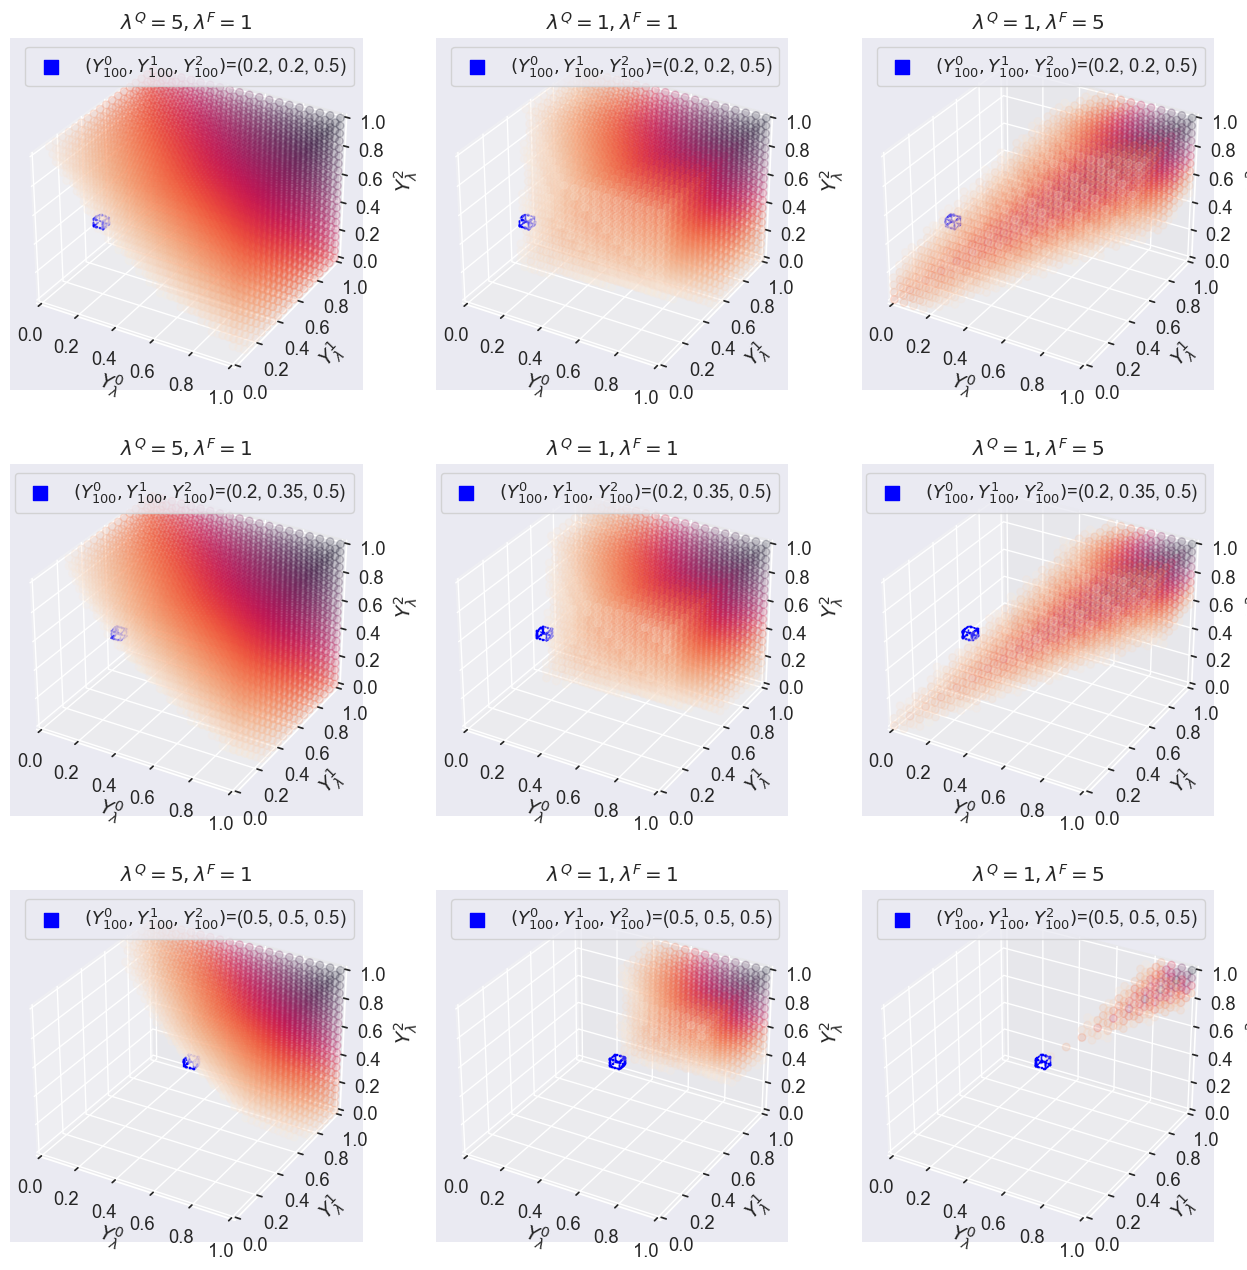

In [356]:
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(13, 13))

N_POINTS = 20
RF_STRATEGY = 'avg'

_, df1 = plot_dRL_z3(fig, 331, Y0_100=.20, Y1_100=.20, Y2_100=.50, lamQ=5, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df2 = plot_dRL_z3(fig, 332, Y0_100=.20, Y1_100=.20, Y2_100=.50, lamQ=1, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df3 = plot_dRL_z3(fig, 333, Y0_100=.20, Y1_100=.20, Y2_100=.50, lamQ=1, lamF=5, n_points=N_POINTS, rf_strategy=RF_STRATEGY)

_, df4 = plot_dRL_z3(fig, 334, Y0_100=.20, Y1_100=.35, Y2_100=.50, lamQ=5, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df5 = plot_dRL_z3(fig, 335, Y0_100=.20, Y1_100=.35, Y2_100=.50, lamQ=1, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df6 = plot_dRL_z3(fig, 336, Y0_100=.20, Y1_100=.35, Y2_100=.50, lamQ=1, lamF=5, n_points=N_POINTS, rf_strategy=RF_STRATEGY)

_, df7 = plot_dRL_z3(fig, 337, Y0_100=.50, Y1_100=.50, Y2_100=.50, lamQ=5, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df8 = plot_dRL_z3(fig, 338, Y0_100=.50, Y1_100=.50, Y2_100=.50, lamQ=1, lamF=1, n_points=N_POINTS, rf_strategy=RF_STRATEGY)
_, df9 = plot_dRL_z3(fig, 339, Y0_100=.50, Y1_100=.50, Y2_100=.50, lamQ=1, lamF=5, n_points=N_POINTS, rf_strategy=RF_STRATEGY)

plt.tight_layout()
plt.show()

### Manually testing Z>3 reward

When Z>2:

**Theorem 4.1** doesn't hold when Z>2. But when Z=2, it can be modified to be "when lambdaF=lambdaQ, none of the non-advantaged groups will be harmed as a result of an increase in the advantaged groups."

**Theorem 4.2** holds, for obvious reasons.

~~**Theorem 4.3** when Z>2, when natural fairness exists, when lambdaF\lambdaQ, at least Z/2 groups are not harmed.~~


In [229]:
def test_reward(lam, Y100, Ylam):
    lD, lQ, lF = lam
    Y0_100, Y1_100, Y2_100 = Y100
    Y0_lam, Y1_lam, Y2_lam = Ylam
    RD = 1/3
    RQ = 1/3 * (
        (Y0_lam - Y0_100) + (Y1_lam - Y1_100) + (Y2_lam - Y2_100)
    )
    Yavg_100 = 1/3*(Y0_100 + Y1_100 + Y2_100)
    Yavg_lam = 1/3*(Y0_lam + Y1_lam + Y2_lam) 
    RF = 1/3 * (
        (abs(Y0_100 - Yavg_100) + abs(Y1_100 - Yavg_100) + abs(Y2_100 - Yavg_100)) -
        (abs(Y0_lam - Yavg_lam) + abs(Y1_lam - Yavg_lam) + abs(Y2_lam - Yavg_lam))
    )
    R = lD*RD + lQ*RQ + lF*RF
    return R, (RD, RQ, RF)
    

In [314]:
print(test_reward(
    lam=(1, 1, 2),
    Y100=(.0001, .0001, .0001),
    Ylam=(.0001, .0001, .0001),
))

print(test_reward(
    lam=(1, 1, 1.5),
    Y100=(.0001, .0001, .0001),
    Ylam=(.0001, 1, 1),
))


(0.3333333333333333, (0.3333333333333333, 0.0, 0.0))
(0.33333333333333326, (0.3333333333333333, 0.6666, -0.4444))


In [ ]:
        _Y0_100, _Y1_100, _Y2_100, _Y0_lam, _Y1_lam, _Y2_lam = point
        
        # Compute dRQ[i]
        dRQ[i] = 1/3* ( (_Y0_lam-_Y0_100) + (_Y1_lam-_Y1_100) + (_Y2_lam-_Y2_100) )
        
        # Compute dRF[i]
        # rQ_* is the average Q for policy *
        rQ_100_avg = (_Y0_100 + _Y1_100 + _Y2_100) / 3
        rQ_lam_avg = (_Y0_lam + _Y1_lam + _Y2_lam) / 3
        dRF_100 = abs(_Y0_100-rQ_100_avg) + abs(_Y1_100-rQ_100_avg) + abs(_Y2_100-rQ_100_avg)
        if rf_strategy == 'avg':
            dRF_lam = abs(_Y0_lam-rQ_lam_avg) + abs(_Y1_lam-rQ_lam_avg) + abs(_Y2_lam-rQ_lam_avg)            
        elif rf_strategy == 'minmax':
            min_idx = np.argmin([_Y0_lam, _Y1_lam, _Y2_lam])
            max_idx = np.argmax([_Y0_lam, _Y1_lam, _Y2_lam])
            _Ymin_lam = [_Y0_lam, _Y1_lam, _Y2_lam][min_idx]
            _Ymax_lam = [_Y0_lam, _Y1_lam, _Y2_lam][max_idx]
            dRF_lam = _Ymax_lam - _Ymin_lam
        else:
            raise ValueError('Invalid rf_strategy')
        # dRF is the average of the diffs from the rQ avg
        dRF[i] = 1/3*(dRF_100 - dRF_lam)

# Scratch

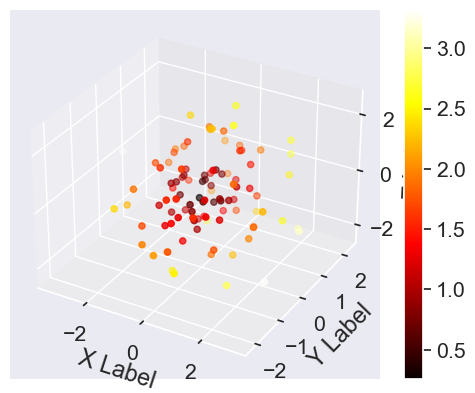

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generating some example data
x = np.random.standard_normal(100)
y = np.random.standard_normal(100)
z = np.random.standard_normal(100)
intensity = np.sqrt(x**2 + y**2 + z**2)  # Example intensity

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Using scatter plot and mapping intensity to color
img = ax.scatter(x, y, z, c=intensity, cmap=plt.hot())
fig.colorbar(img)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


### Scenario A(i) - runaway advantaged group

Harm to $Z=0$ due to  $(Y^1_\lambda \gg Y^1_{{100}}) \wedge (\lambda^Q \gg \lambda^F)$

/Users/jb846j/miniconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/jb846j/miniconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


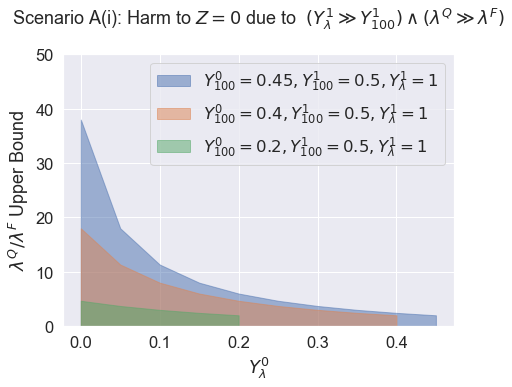

In [242]:
N_POINTS = 21
points = np.linspace(0, 1, N_POINTS)
# Generate permutations of points
grid = np.stack(np.meshgrid(points, points, points, points), -1).reshape(-1, 4)
dRQ = np.empty(N_POINTS**4)
dRF = np.empty(N_POINTS**4)

for i, point in enumerate(grid):
    Y0_100, Y1_100, Y0_lam, Y1_lam = point
    dRQ[i] = .5*(Y0_lam - Y0_100) + .5*(Y1_lam - Y1_100)
    dRF[i] = (Y1_100 - Y0_100) - (Y1_lam - Y0_lam)

# Generate dataframe
df = pd.DataFrame(grid, columns=['Y0_100', 'Y1_100', 'Y0_lam', 'Y1_lam'])
df['dRQ'] = dRQ
df['dRF'] = dRF
df['dRF'] = dRF
df['neg_dRF_over_dRQ'] = -1 * dRF / dRQ

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
perms = [
#          [.45, .5, .95],
         [.45, .5, 1],
         [.4, .5, 1],
         [.2, .5, 1],
        ]

for i, perm in enumerate(perms):
    _Y0_100 = perm[0]
    _Y1_100 = perm[1]
    _Y1_lam = perm[2]
    _df = (df.query('Y0_lam <= @_Y0_100'))  # Filter to only harm conditions
    _df = _df[np.isclose(_df['Y0_100'], _Y0_100)]
    _df = _df[np.isclose(_df['Y1_100'], _Y1_100)]
    _df = _df[np.isclose(_df['Y1_lam'], _Y1_lam)]

    label = f'$Y^0_{{100}}={_Y0_100}, Y^1_{{100}}={_Y1_100}, Y^1_{{\lambda}}={_Y1_lam}$'
    ax.fill_between(_df['Y0_lam'], _df['neg_dRF_over_dRQ'], label=label, alpha=.5, color=cp[i])
    
ax.set_title('Scenario A(i): Harm to $Z=0$ due to  $(Y^1_\lambda \gg Y^1_{{100}}) \wedge (\lambda^Q \gg \lambda^F)$\n')
ax.legend()
ax.set_xlabel('$Y^0_\lambda$')
ax.set_ylabel('$\lambda^Q/\lambda^F$ Upper Bound')
ax.set_ylim([0, 50])
plt.show()

The y-axis shows the minimum $\lambda^Q/\lambda^F$ ratio that will make the stated $Y^0_\lambda, Y^1_\lambda$ values optimal under $R^\lambda$. 

Therefore, interpret the chart as: if your Y values are as labeled, then your $\lambda^Q/\lambda^F$ ratio needs to be under the shaded curve in order to guarantee that no harm is done to the $Z=0$ group.

What this plot shows then is that your ratio $\lambda^Q/\lambda^F$ needs to decrease as $Y^0_{100}$ decreases.

Example: Let's say that your initial $Y$ values are $Y^0_{{100}}=.4$ and $Y^1_{{100}}=.5$, which is shown as the orange curve in the plot. Then if you set your $\lambda^Q/\lambda^F < 18$ then you will guarantee that no harm is done to $Z=0$ (under Scenario A(i)) regardless of what $Y^0_\lambda$ and $Y^1_\lambda$ end up being. This is because even if we consider the "easiest" way to induce harm under this scenario, which occurs when $Y^1_\lambda=1$ and $Y^0_\lambda=0$, then having a $\lambda^Q/\lambda^F$ ratio of less than 18 will make that outcome less optimal than the cost optimal policy.

In [ ]:
.20: 4.67,
.25: 6, 
.30: 8,
.35: 11.33
.40: 18,
.45: 38
    

.05 : 2x
    
    

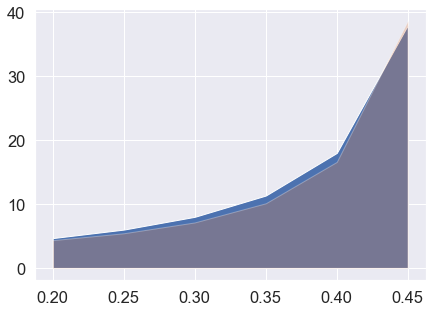

In [133]:
x = np.array([.2, .25, .3, .35, .4, .45])
y = np.array([4.67, 6, 8, 11.33, 18, 38])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.fill_between(x, y)
# ax.fill_between(x, 2**(x+3), alpha=.1)
ax.fill_between(x, 1/((.5-x)**1.22), alpha=.3)

### Scenario A(ii)

Harm to $Z=1$ due to  $(Y^1_\lambda - Y^0_\lambda) \ll (Y^1_0 - Y^0_0) \wedge (\lambda^F \gg \lambda^Q)$

/Users/jb846j/miniconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/jb846j/miniconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


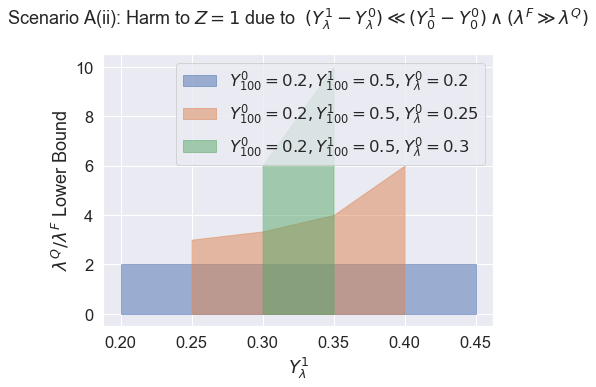

In [599]:
N_POINTS = 21
points = np.linspace(0, 1, N_POINTS)
# Generate permutations of points
grid = np.stack(np.meshgrid(points, points, points, points), -1).reshape(-1, 4)
dRQ = np.empty(N_POINTS**4)
dRF = np.empty(N_POINTS**4)

for i, point in enumerate(grid):
    Y0_100, Y1_100, Y0_lam, Y1_lam = point
    dRQ[i] = .5*(Y0_lam - Y0_100) + .5*(Y1_lam - Y1_100)
    dRF[i] = abs(Y1_100 - Y0_100) - abs(Y1_lam - Y0_lam)

# Generate dataframe
df = pd.DataFrame(grid, columns=['Y0_100', 'Y1_100', 'Y0_lam', 'Y1_lam'])
df['dRQ'] = dRQ
df['dRF'] = dRF
df['dRF'] = dRF
df['neg_dRF_over_dRQ'] = -1 * dRF / dRQ

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
perms = [
    [.2, .5, .2],
    [.2, .5, .25],
    [.2, .5, .3],
]

for i, perm in enumerate(perms):
    _Y0_100 = perm[0]
    _Y1_100 = perm[1]
    _Y0_lam = perm[2]
    _df = df.copy()
    _df = _df[np.isclose(_df['Y0_100'], _Y0_100)]
    _df = _df[np.isclose(_df['Y1_100'], _Y1_100)]
    _df = _df[np.isclose(_df['Y0_lam'], _Y0_lam)]
    _df = _df.query('Y1_lam < @_Y1_100')  # Filter to only harm conditions
    _df = _df.query('Y1_lam >= Y0_lam')  # Ensure Scenario A
    _df = _df.query('dRQ < 0')  # Ensure overall qualification did not improve

    label = f'$Y^0_{{100}}={_Y0_100}, Y^1_{{100}}={_Y1_100}, Y^0_\lambda={_Y0_lam}$'
    ax.fill_between(_df['Y1_lam'], _df['neg_dRF_over_dRQ'], label=label, alpha=.5, color=cp[i])
    
ax.set_title('Scenario A(ii): Harm to $Z=1$ due to  $(Y^1_\lambda - Y^0_\lambda) \ll (Y^1_0 - Y^0_0) \wedge (\lambda^F \gg \lambda^Q)$\n')
ax.legend()
ax.set_xlabel('$Y^1_\lambda$')
ax.set_ylabel('$\lambda^Q/\lambda^F$ Lower Bound')
# ax.set_ylim([-50, 50])
plt.show()

In [814]:
def plot_dRL(ax, Y0_100, Y1_100, lamQ, lamF):
    N_POINTS = 21
    points = np.linspace(0, 1, N_POINTS)
    # Generate permutations of points
    grid = np.stack(np.meshgrid([Y0_100], [Y1_100], points, points), -1).reshape(-1, 4)
    dRQ = np.empty(N_POINTS**2)
    dRF = np.empty(N_POINTS**2)

    for i, point in enumerate(grid):
        _Y0_100, _Y1_100, _Y0_lam, _Y1_lam = point
        dRQ[i] = .5*(_Y0_lam - _Y0_100) + .5*(_Y1_lam - _Y1_100)
        dRF[i] = abs(_Y1_100 - _Y0_100) - abs(_Y1_lam - _Y0_lam)

    # Generate dataframe
    df = pd.DataFrame(grid, columns=['Y0_100', 'Y1_100', 'Y0_lam', 'Y1_lam'])
    df['dRQ'] = dRQ
    df['dRF'] = dRF
    df['dRF'] = dRF
    df['neg_dRF_over_dRQ'] = -1 * dRF / dRQ
    df = df.copy()
    df['lamQdRQ_plus_lamFdRF'] = (lamQ*dRQ + lamF*dRF) / (lamQ+lamF)

    _df = df.copy()
    _df = _df[np.isclose(_df['Y0_100'], Y0_100)]
    _df = _df[np.isclose(_df['Y1_100'], Y1_100)]
#     _df = _df.query('Y1_lam >= Y0_lam')  # Ensure Scenario A
    # _df = _df.query('Y0_lam <= Y0_100')  # Ensure Y0 didn't improve
    # _df = _df.query('dRQ < 0')  # Ensure overall qualification did not improve
    # _df = _df.query('neg_dRF_over_dRQ > 0')
#     _df = _df.query('lamQdRQ_plus_lamFdRF > 0')  # Ensure optimal under Rlambda

    piv = _df.pivot('Y1_lam', 'Y0_lam', 'lamQdRQ_plus_lamFdRF')

    ax = sns.heatmap(piv, ax=ax, vmin=0, vmax=.5, annot=False)
    cbar = ax.collections[0].colorbar
    cbar.set_label('$\Delta R^\lambda$', rotation=0, labelpad=25)
    ax.invert_yaxis()
    ax.set_xlabel('$Y^0_\lambda$')
    ax.set_ylabel('$Y^1_\lambda$', rotation=0, labelpad=20)
    ax.scatter([Y0_100*ax.get_xlim()[1]], [Y1_100*ax.get_ylim()[1]],
               label=f'$(Y^0_{{100}}, Y^1_{{100}})$=({Y0_100}, {Y1_100})', s=100)
    ax.legend(loc='lower right')
    ax.set_title(f'$\lambda^Q={lamQ}, \lambda^F={lamF}$')
    xlabels = [f'{x:.1f}' for x in np.linspace(_df['Y0_lam'].min(), _df['Y0_lam'].max(), len(ax.get_xticks()))]
    ylabels = [f'{y:.1f}' for y in np.linspace(_df['Y1_lam'].min(), _df['Y1_lam'].max(), len(ax.get_yticks()))]
    ax.set_xticklabels(xlabels, ha='center', rotation=0)
    ax.set_yticklabels(ylabels, va='center')
    return ax
